In [28]:
import torch
from torch import nn

from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T

from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [29]:
class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, img_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir)) if mask_dir else None

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")

        if self.mask_paths:
            mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])
            mask = Image.open(mask_path).convert("L")

            if self.img_transform:
                image = self.img_transform(image)
            if self.mask_transform:
                mask = self.mask_transform(mask)
            return image, mask
        else:
            if self.img_transform:
                image = self.img_transform(image)
            return image

In [30]:
# For images
img_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# For masks
mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    T.ToTensor(),  # will keep it as float [0,1] with shape [1, H, W]
    T.Lambda(lambda x: (x > 0.5).float())  # binarize mask
])

train_dataset = CarvanaDataset(
    image_dir="aug_images",
    mask_dir="aug_masks",
    img_transform=img_transform,
    mask_transform=mask_transform
)

test_dataset = CarvanaDataset(
    image_dir="test",
    img_transform=img_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

In [31]:
def center_crop(encoder_feature, target_tensor):
    _, _, H, W = target_tensor.shape
    enc_H, enc_W = encoder_feature.shape[2], encoder_feature.shape[3]
    crop_H = (enc_H - H) // 2
    crop_W = (enc_W - W) // 2
    return encoder_feature[:, :, crop_H:crop_H+H, crop_W:crop_W+W]

In [32]:
class UNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )

        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.encoder4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.encoder5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )


        # Decoder
        self.upconv_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.decoder1 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        

        self.upconv_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        

        self.upconv_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        

        self.upconv_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)


    def forward(self, image):

        # Encoder
        e1 = self.encoder1(image)
        e2 = self.encoder2(self.max_pool_2x2(e1))
        e3 = self.encoder3(self.max_pool_2x2(e2))
        e4 = self.encoder4(self.max_pool_2x2(e3))
        e5 = self.encoder5(self.max_pool_2x2(e4))

        # Decoder
        d1 = self.upconv_1(e5)
        c1 = center_crop(e4, d1)
        d1 = torch.cat([d1, c1], dim=1)
        d1 = self.decoder1(d1)
        
        d2 = self.upconv_2(d1)
        c2 = center_crop(e3, d2)
        d2 = torch.cat([d2, c2], dim=1)
        d2 = self.decoder2(d2)

        d3 = self.upconv_3(d2)
        c3 = center_crop(e2, d3)
        d3 = torch.cat([d3, c3], dim=1)
        d3 = self.decoder3(d3)

        d4 = self.upconv_4(d3)
        c4 = center_crop(e1, d4)
        d4 = torch.cat([d4, c4], dim=1)
        d4 = self.decoder4(d4)

        # Final output
        out = self.final_conv(d4)

        return out

In [33]:
def init_weights(module):
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0)

In [34]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [35]:
model = UNet()
model = model.to(device)

In [36]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
    def forward(self, pred, target):
        return self.bce(pred, target) + dice_loss(pred, target)

In [37]:
criterion = BCEDiceLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
learning_rate = 0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [38]:
epochs = 10
batch_size = 8
n_train = len(train_loader.dataset)  # or hardcode a value if needed
n_val = len(test_loader.dataset) if 'val_loader' in globals() else 0
save_checkpoint = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_scale = 1.0
amp = False  # or True if you're using mixed precision training

patience = 3
patience_counter = 0

In [39]:
import logging
import os
import sys
from datetime import datetime
from tqdm.notebook import tqdm 

# Create logs directory
os.makedirs("logs4", exist_ok=True)

# Timestamped log file
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_file = f"logs4/train_{timestamp}.log"

# Configure logging
logging.basicConfig(
    filename=log_file,
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


best_loss = float('inf')
checkpoint_path = "best_model_new.pth"

# Config
epochs = 10  # OR use num_epochs and change below
logging.info(f'''Starting training:
    Epochs:          {epochs}
    Batch size:      {batch_size}
    Learning rate:   {learning_rate}
    Training size:   {n_train}
    Validation size: {n_val}
    Checkpoints:     {save_checkpoint}
    Device:          {device.type}
    Image scaling:   {img_scale}
    Mixed Precision: {amp}
''')


if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    logging.info(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0
    

# Training loop
for epoch in range(start_epoch, epochs):
    model.train()
    epoch_loss = 0.0

    logging.info(f"Epoch {epoch+1}/{epochs} started.")
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        _, _, h, w = outputs.shape
        masks_cropped = masks[:, :, :h, :w]

        loss = criterion(outputs, masks_cropped)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    

    avg_loss = epoch_loss / len(train_loader)


    if save_checkpoint and avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, checkpoint_path)
            logging.info(f"Saved checkpoint at epoch {epoch+1} with loss {best_loss:.6f}")


    if avg_loss < best_loss:
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        logging.info(f"Early stopping triggered at epoch {epoch+1}")
        print("Early stopping")
        break
            
    
    # Scheduler step
    scheduler.step(avg_loss)


Epoch 3/10


Training:   0%|          | 0/6260 [00:00<?, ?it/s]


Epoch 4/10


Training:   0%|          | 0/6260 [00:00<?, ?it/s]


Epoch 5/10


Training:   0%|          | 0/6260 [00:00<?, ?it/s]

Early stopping


In [47]:
torch.save(model.state_dict(), "unet_car_final.pth")

In [49]:
# re-create model architecture
model = UNet().to(device)

# load saved weights
# checkpoint = torch.load("unet_car_final.pth", map_location=device)
# model.load_state_dict(checkpoint["model_state_dict"])

model.load_state_dict(torch.load("unet_car_final.pth", map_location=device))
model.eval()

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3

In [50]:
import matplotlib.pyplot as plt

# load and preprocess an image (same transform as training)
image = Image.open("test/79_Swift.jpg").convert("RGB")
input_tensor = img_transform(image).unsqueeze(0).to(device)  # [1, 3, H, W]

# prediction
with torch.no_grad():
    output = model(input_tensor)  # shape: [1, 1, H, W]
    pred_mask = torch.sigmoid(output)  # convert logits to probabilities
    pred_mask = (pred_mask > 0.5).float()  # thresholding

In [51]:
import torchvision.transforms.functional as TF
from PIL import Image

# Convert input tensor [C,H,W] -> [H,W,C] numpy
img_np = np.array(image)

# Get input image size (H, W)
h, w = img_np.shape[:2]

# Resize predicted mask back to input size
pred_mask_resized = TF.resize(
    TF.to_pil_image(pred_mask.squeeze().cpu()), 
    size=(h, w), 
    interpolation=Image.NEAREST  # keep it binary, no blurring
)

# Convert back to numpy for plotting
pred_mask_resized = np.array(pred_mask_resized)

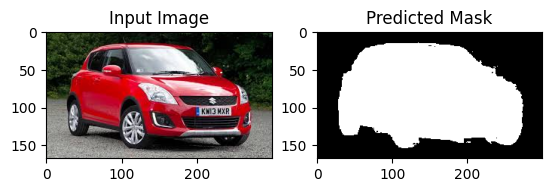

In [52]:
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(pred_mask_resized, cmap="gray")
plt.title("Predicted Mask")
plt.show()

In [53]:
from torch.utils.data import DataLoader

val_image_dir = "val_images"
val_mask_dir = "val_masks"

# For validation images
val_img_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# For validation masks
def binarize_mask(x):
    return (x > 0.5).float()

val_mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=InterpolationMode.NEAREST),
    T.ToTensor(),
    binarize_mask  # ✅ now works with multiple workers
])

# Validation dataset
val_dataset = CarvanaDataset(
    image_dir=val_image_dir,
    mask_dir=val_mask_dir,
    img_transform=val_img_transform,
    mask_transform=val_mask_transform
)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

In [54]:
import torch
import torch.nn.functional as F

def dice_coeff(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    # Ensure shape match
    if pred.shape != target.shape:
        target = target.unsqueeze(1)  # (B,H,W) -> (B,1,H,W)
    
    intersection = (pred * target).sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + smooth)
    return dice.mean()   # average over batch

def iou_coeff(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    if pred.shape != target.shape:
        target = target.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [55]:
def evaluate(model, loader, device):
    model.eval()
    dice_scores, iou_scores = [], []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            dice = dice_coeff(outputs, masks)
            iou = iou_coeff(outputs, masks)

            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_iou = sum(iou_scores) / len(iou_scores)
    return avg_dice, avg_iou

# Run evaluation
val_dice, val_iou = evaluate(model, val_loader, device)
print(f"Validation Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")


Validation Dice: 0.9900, IoU: 0.9804
